# Forests of randomized trees

The `sklearn.ensemble` module includes two averaging algorithms based on randomized decision trees: the **RandomForest** algorithm and the **Extra-Trees** method. Both algorithms are perturb-and-combine techniques specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of shape `(n_samples, n_features)` holding the training samples, and an array Y of shape `(n_samples,)` holding the target values (class labels) for the training samples:

In [2]:
from sklearn.ensemble import RandomForestClassifier
X = [[0,0],[1,1]]
Y = [0,1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)

In [3]:
import numpy as np
x = np.array([[0,0],[1,1]])
y = np.array([0,1])
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x, y)

Like decision trees, forests of trees also extend to multi-output problems (if Y is an array of shape `(n_samples, n_outputs)`).

## Random Forests
In random forests (see `RandomForestClassifier` and `RandomForestRegressor` classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size `max_features`. 

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.


The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

## Extremely Randomized Trees

In extremely randomized trees (see `ExtraTreesClassifier` and `ExtraTreesRegressor` classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=1000, n_features=10, centers=100, random_state=0)

clf_tree = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores_tree = cross_val_score(clf_tree, X, y, cv=5)
print("Decision tree mean score: ",scores_tree.mean())

clf_forest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores_forest = cross_val_score(clf_forest, X, y, cv=5)
print("Random forest mean score: ",scores_forest.mean())

clf_extratree = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores_extratree = cross_val_score(clf_extratree, X, y, cv=5)
print("Extremely Randomized mean score: ",scores_extratree.mean())

print("Extremely Randomized Trees beat Random Forest?", scores_extratree.mean()>scores_tree.mean())


Decision tree mean score:  0.8860000000000001
Random forest mean score:  0.9960000000000001
Extremely Randomized mean score:  0.9970000000000001
Extremely Randomized Trees beat Random Forest? True


## Parameters
The main parameters to adjust when using these methods is `n_estimators` and `max_features`.
- `n_estimators`: It is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. 
- `max_features`: It is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are `max_features=None` (always considering all features instead of a random subset) for **regression problems**, and `max_features="sqrt"` (using a random subset of size sqrt(n_features)) for **classification tasks** (where n_features is the number of features in the data). 
  
**Good results** are often achieved when setting **max_depth=None** in combination with **min_samples_split=2** (i.e., when fully developing the trees). Bear in mind though that **these values are usually not optimal**, and might result in models that consume a lot of RAM. The **best parameter values should always be cross-validated.** In addition, note that **in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False).** When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting `oob_score=True`.

## Parallelization
This module also features the parallel construction of the trees and the parallel computation of the predictions through the n_jobs parameter. If `n_jobs=k` then computations are partitioned into `k` jobs, and run on `k` cores of the machine. If `n_jobs=-1` then **all cores available on the machine are used.** Note that because of inter-process communication overhead, the speedup might not be linear (i.e., **using k jobs will unfortunately not be k times as fast**). **Significant speedup can still be achieved** though when building a large number of trees, or when building a single tree requires a fair amount of time (e.g., on large datasets).



-----------
# Pixel importances with a parallel forest of trees

This example shows the use of a forest of trees to evaluate the impurity based importance of the pixels in an image classification task on the faces dataset. The hotter the pixel, the more important it is.

The code below also illustrates how the construction and the computation of the predictions can be parallelized within multiple jobs.

## Loading the data and model fitting
First, we load the olivetti faces dataset and limit the dataset to contain only the first five classes. Then we train a random forest on the dataset and evaluate the impurity-based feature importance. One drawback of this method is that it cannot be evaluated on a separate test set. For this example, we are interested in representing the information learned from the full dataset. Also, we’ll set the number of cores to use for the tasks.

In [5]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
n_jobs = -1 #use every available core
data = fetch_olivetti_faces()
X, y = data.data, data.target

#limit the dataset to 5 classes. 10 foto for each expression. 
#just pick the first 5 expressions of each person. 10 person in total
mask = y < 5
X = X[mask]
y = y[mask]

forest = RandomForestClassifier(n_estimators=750, n_jobs=n_jobs, random_state=42)
forest.fit(X,y)

RandomForestClassifier(n_estimators=750, n_jobs=-1, random_state=42)

## Feature importance based on mean decrease in impurity (MDI)
Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**Warning:** Impurity-based feature importances can be **misleading for high cardinality** features (many unique values). See Permutation feature importance [https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance] as an alternative.

Elapsed time to compute the importances: 0.111 seconds


<Figure size 1728x1440 with 0 Axes>

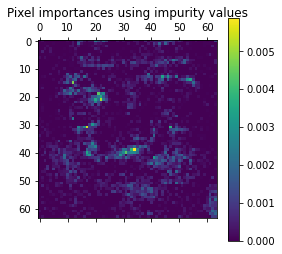

In [8]:
import time
import matplotlib.pyplot as plt

start_time = time.time()
img_shape = data.images[0].shape
importances = forest.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
imp_reshaped = importances.reshape(img_shape)
plt.figure(figsize=(12*2,10*2))
plt.matshow(imp_reshaped, cmap=plt.cm.viridis)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

---------

# Plot the decision surfaces of ensembles of trees on the iris dataset

Plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier (first column), by a random forest classifier (second column), by an extra- trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and the sepal length features only, on the second row using the petal length and sepal length only, and on the third row using the petal width and the petal length only.

In descending order of quality, when trained (outside of this example) on all 4 features using 30 estimators and scored using 10 fold cross validation, we see:
```
ExtraTreesClassifier()  # 0.95 score
RandomForestClassifier()  # 0.94 score
AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
DecisionTree(max_depth=None)  # 0.94 score
```

Increasing `max_depth` for `AdaBoost` lowers the standard deviation of the scores (but the average score does not improve).

See the console’s output for further details about each model.

In this example you might try to:

- vary the `max_depth` for the `DecisionTreeClassifier` and `AdaBoostClassifier`, perhaps try `max_depth=3` for the `DecisionTreeClassifier` or `max_depth=None` for `AdaBoostClassifier`
- vary `n_estimators`
It is worth noting that RandomForests and ExtraTrees can be fitted in parallel on many cores as each tree is built independently of the others. **AdaBoost’s samples are built sequentially and so do not use multiple cores.**

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators. with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators. with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators. with features [0, 1] has a score of 0.8533333333333334
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators. with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators. with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators. with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators. with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators. with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators. with features [2, 3] has a score of 0.9933333333333333


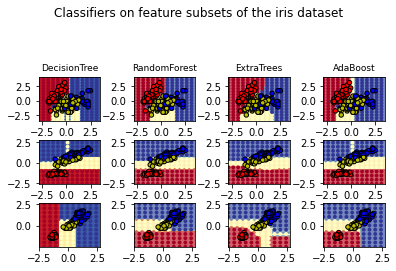

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Parameters
n_classes = 3 #iris classes: virginica, versicolor, setosa
n_estimators = 30 #number of trees in ensemble methods
cmap = plt.cm.RdYlBu
plot_step = 0.02 #fine step width for decision surface contours
plot_step_coarser = 0.5 #step widths for coarse classifier guesses
RANDOM_SEED = 13 #fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators, max_depth=None),
    ExtraTreesClassifier(n_estimators=n_estimators, max_depth=None),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators)
]

# In the first row, the classifiers are built using 
# the sepal width and the sepal length features only, 
# on the second row using the petal length and sepal length only, 
# and on the third row using the petal width and the petal length only.
# data type are 
# (0,1): sepal length, sepal width
# (0,2): sepal length, petal length 
# (2,3): petal length, petal width
for pair in ([0,1], [0,2], [2,3]):
    for model in models:
        # We only take the 2 corresponding features
        X = iris.data[:, pair]
        y = iris.target
        
        # Shuffle
        idx = np.arange(X.shape[0]) # how many rows -> how many indexes
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        
        # Standardize
        mean = X.mean(axis=0) # mean of the column
        std = X.std(axis=0)
        X = (X - mean) / std
        
        # Train
        model.fit(X,y)
        
        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split('.')[-1][:-2][:-len("Classifier")]
        
        model_details = model_title
        if hasattr(model, 'estimators_'):
            model_details += f" with {len(model.estimators_)} estimators."
        print(model_details + " with features", pair, 'has a score of', scores)
        
        plt.subplot(3,4, plot_idx) #starting index
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)
        
        # Plot the decision boundary using a fine mesh as input to a 
        # filled contour plot
        x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
        
        # FINE RESULTS
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )
        
        # Plot either a single decision tree or alpha blend the 
        # decision surfaces of the ensemble of classifiers  
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            estimator_alpha=1.0/len(model.estimators_)
            for tree in model.estimators_:
                Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)
                
        # COARSE RESULTS
        
        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )
        
        # Plot the training points, these are clustered together and have a 
        # black outline
        plt.scatter(
            X[:,0], X[:,1],
            c=y,
            cmap=ListedColormap(['r','y','b']),
            edgecolor='k',
            s=20,
        )   
        plot_idx += 1 # move on the next plot in sequence     
        
plt.suptitle("Classifiers on feature subsets of the iris dataset", fontsize=12)
plt.axis('tight')
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.savefig('Iris - Ensamble methods vs decision trees', dpi=500)
plt.show()

# Adaboost
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights 
$w_1, w_2, …, w_N$ to each of the training samples. Initially, those weights are all set to $w_i=1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

In [8]:
iris.keys()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [13]:
str(type(DecisionTreeClassifier())).split('.')
str(type(DecisionTreeClassifier())).split('.')[-1]
str(type(DecisionTreeClassifier())).split('.')[-1][:-2]

'DecisionTreeClassifier'

NameError: name 'X' is not defined